In [25]:
import numpy as np
import pandas as pd
import xlearn as xl

In [2]:
df = pd.read_csv('data.csv', usecols=['date_time','zone_id','banner_id','oaid_hash',
                                      'campaign_clicks','os_id','country_id','clicks'], 
                 dtype={'zone_id':str,'banner_id':str,'oaid_hash':str,'os_id':str,'country_id':str,'clicks':int},
                 parse_dates=['date_time'],)
df.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks
0,2021-09-27 00:01:30,0,0,5664530014561852622,0,0,0,1
1,2021-09-26 22:54:49,1,1,5186611064559013950,0,0,1,1
2,2021-09-26 23:57:20,2,2,2215519569292448030,3,0,0,1
3,2021-09-27 00:04:30,3,3,6262169206735077204,0,1,1,1
4,2021-09-27 00:06:21,4,4,4778985830203613115,0,1,0,1


In [3]:
df = df.set_index('date_time')

In [18]:
train = df.loc[:'2021-09-30'].copy()
val = df.loc['2021-10-01'].copy()
test = df.loc['2021-10-02'].copy()

## Преобразование данных в формат libffm

In [17]:
TARGET = ['clicks']
NUMERICAL_FEATURES = ['campaign_clicks']
CATEGORICAL_FEATURES = ['zone_id','banner_id','oaid_hash','os_id','country_id']
ALL_FEATURES = ['zone_id','banner_id','oaid_hash','campaign_clicks','os_id','country_id']
NUM_THREADS = 4

In [21]:
import json
import math

def _convert_to_ffm(path, df, type, target, numerics, categories, features, encoder):
    # Flagging categorical and numerical fields
    print('convert_to_ffm - START')
    for x in numerics:
        if(x not in encoder['catdict']):
            print(f'UPDATING CATDICT: numeric field - {x}')
            encoder['catdict'][x] = 0
    for x in categories:
        if(x not in encoder['catdict']):
            print(f'UPDATING CATDICT: categorical field - {x}')
            encoder['catdict'][x] = 1

    nrows = df.shape[0]
    with open(path + str(type) + "_ffm.txt", "w") as text_file:

        # Looping over rows to convert each row to libffm format
        for n, r in enumerate(range(nrows)):
            datastring = ""
            datarow = df.iloc[r].to_dict()
            datastring += str(int(datarow[target]))  # Set Target Variable here

            # For numerical fields, we are creating a dummy field here
            for i, x in enumerate(encoder['catdict'].keys()):
                if(encoder['catdict'][x] == 0):
                    # Not adding numerical values that are nan
                    if math.isnan(datarow[x]) is not True:
                        datastring = datastring + " "+str(i)+":" + str(i)+":" + str(datarow[x])
                else:

                    # For a new field appearing in a training example
                    if(x not in encoder['catcodes']):
                        # print(f'UPDATING CATCODES: categorical field - {x}')
                        encoder['catcodes'][x] = {}
                        encoder['currentcode'] += 1
                        # print(f'UPDATING CATCODES: categorical value for field {x} - {datarow[x]}')
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    # For already encoded fields
                    elif(datarow[x] not in encoder['catcodes'][x]):
                        encoder['currentcode'] += 1
                        # print(f'UPDATING CATCODES: categorical value for field {x} - {datarow[x]}')
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    code = encoder['catcodes'][x][datarow[x]]
                    datastring = datastring + " "+str(i)+":" + str(int(code))+":1"

            datastring += '\n'
            text_file.write(datastring)

    # print('Encoder Summary:')
    # print(json.dumps(encoder, indent=4))
    return encoder

encoder = {"currentcode": len(NUMERICAL_FEATURES),
           "catdict": {},
           "catcodes": {}}

encoder = _convert_to_ffm('', train, 'train', TARGET[0],
                          NUMERICAL_FEATURES,
                          CATEGORICAL_FEATURES,
                          ALL_FEATURES,
                          encoder)

encoder = _convert_to_ffm('', val, 'val', TARGET[0],
                          NUMERICAL_FEATURES,
                          CATEGORICAL_FEATURES,
                          ALL_FEATURES,
                          encoder)

encoder = _convert_to_ffm('', test, 'test', TARGET[0],
                          NUMERICAL_FEATURES,
                          CATEGORICAL_FEATURES,
                          ALL_FEATURES,
                          encoder)

convert_to_ffm - START
UPDATING CATDICT: numeric field - campaign_clicks
UPDATING CATDICT: categorical field - zone_id
UPDATING CATDICT: categorical field - banner_id
UPDATING CATDICT: categorical field - oaid_hash
UPDATING CATDICT: categorical field - os_id
UPDATING CATDICT: categorical field - country_id
convert_to_ffm - START
convert_to_ffm - START


## Построение модели

In [22]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("train_ffm.txt")
ffm_model.setValidate("val_ffm.txt")
param = {'task': 'binary',
         'lr': 0.2,
         'lambda': 0.002,
         'metric': 'auc'}
ffm_model.fit(param, 'model.out')

xLearn выводит текст в консоли, приложу картинку, чтобы отображалось в GitHub.

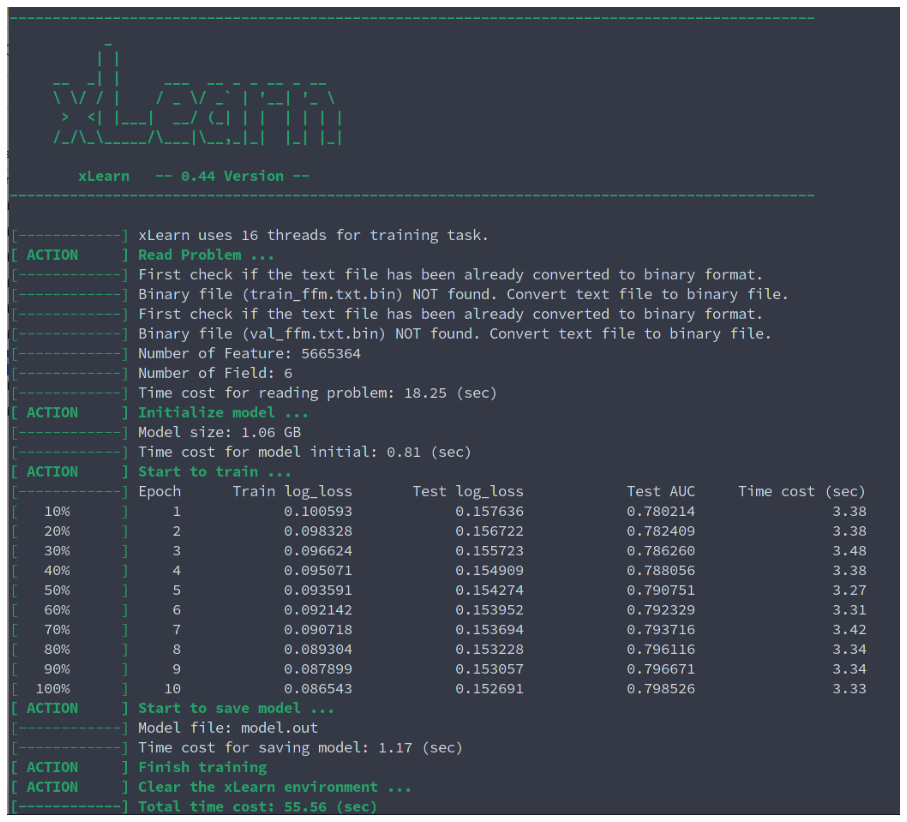

In [30]:
import matplotlib.pyplot as plt
img = plt.imread('train.png')
plt.figure(figsize=(16,16))
plt.imshow(img)
plt.axis('off')
plt.show()

In [23]:
ffm_model.setTest("test_ffm.txt")
ffm_model.setSigmoid()
ffm_model.predict("model.out", "predictions.txt")

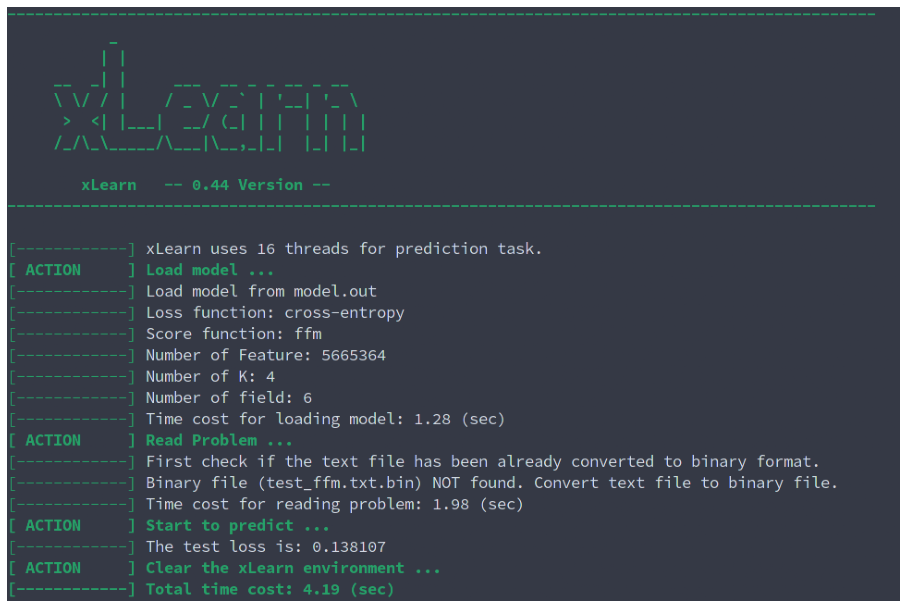

In [31]:
img = plt.imread('test.png')
plt.figure(figsize=(16,16))
plt.imshow(img)
plt.axis('off')
plt.show()

Получили более точный результат test loss: 0.138107   
по сравнению с линейной моделью test loss: 0.144988